In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mtalbert = pd.read_csv('../Data/soil data/AcrossAucklandRainfallStation/MtAlbert_Data_15mins.csv', index_col=['Timestamp (UTC+12:00)'], parse_dates=['Timestamp (UTC+12:00)'])
mtalbert.head()

,Rain(mm),SoilTemp(c),SoilMoisture(%)
Timestamp (UTC+12:00),,,
2018-07-07 11:15:00,0.0,10.4,37.364
2018-07-07 11:30:00,0.0,10.4,37.594
2018-07-07 11:45:00,0.0,10.4,37.590
2018-07-07 12:00:00,0.0,10.5,37.587
2018-07-07 12:15:00,0.0,10.5,37.584


Resample Data to 60 minutes interval

In [ ]:

mtalbert_hourly = mtalbert.resample('H').agg({
    'Rain(mm)': 'sum',
    'SoilTemp(c)': 'mean',
    'SoilMoisture(%)': 'mean'
})

C:\Users\Ying\AppData\Local\Temp\ipykernel_19620\1263614667.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  mtalbert_hourly = mtalbert.resample('H').agg({


In [ ]:
mtalbert_hourly.head()

,Rain(mm),SoilTemp(c),SoilMoisture(%)
Timestamp (UTC+12:00),,,
2018-07-07 11:00:00,0.0,10.400,37.51600
2018-07-07 12:00:00,0.0,10.600,37.52375
2018-07-07 13:00:00,0.0,10.700,37.57200
2018-07-07 14:00:00,0.0,10.725,37.34300
2018-07-07 15:00:00,0.0,10.950,37.35050


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

In [ ]:
mtalbert_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 55162 entries, 2018-07-07 11:00:00 to 2024-10-21 20:00:00
Freq: h
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rain(mm)         55162 non-null  float64
 1   SoilTemp(c)      46897 non-null  float64
 2   SoilMoisture(%)  46897 non-null  float64
dtypes: float64(3)
memory usage: 1.7 MB


In [ ]:
mtalbert.isna().sum()


Rain(mm)           0
SoilTemp(c)        0
SoilMoisture(%)    0
dtype: int64

In [ ]:
mtalbert_hourly = mtalbert_hourly.dropna(subset=['SoilTemp(c)', 'SoilMoisture(%)'])
mtalbert_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 46897 entries, 2018-07-07 11:00:00 to 2024-10-21 20:00:00
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rain(mm)         46897 non-null  float64
 1   SoilTemp(c)      46897 non-null  float64
 2   SoilMoisture(%)  46897 non-null  float64
dtypes: float64(3)
memory usage: 1.4 MB


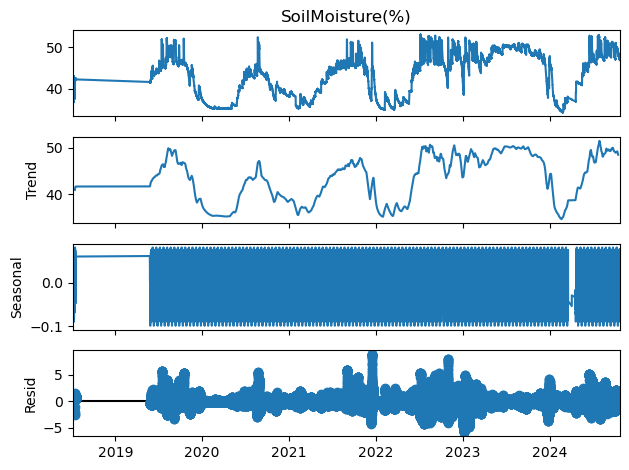

In [ ]:
mtalbert_hourly.index = pd.to_datetime(mtalbert_hourly.index)
period = 365

result = seasonal_decompose(mtalbert_hourly['SoilMoisture(%)'], model='add', period=period)
result.plot()
plt.show()

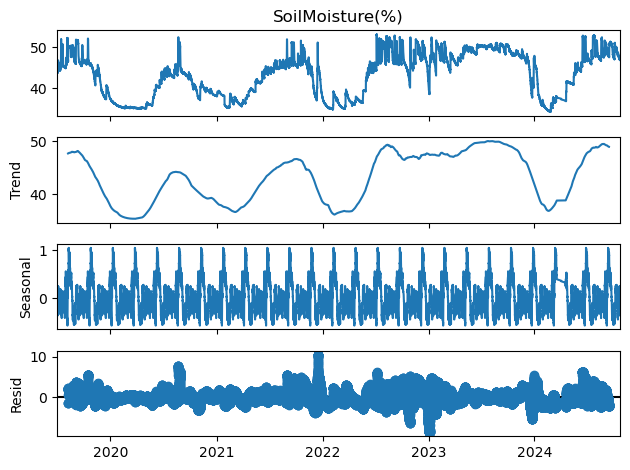

In [ ]:
mtalbert_filtered = mtalbert_hourly.loc['2019-07-01':]
period = 365 * 5

result = seasonal_decompose(mtalbert_filtered['SoilMoisture(%)'], model='add', period=period)
result.plot()
plt.show()

In [ ]:
new_df = result.seasonal



<Axes: xlabel='Timestamp (UTC+12:00)'>

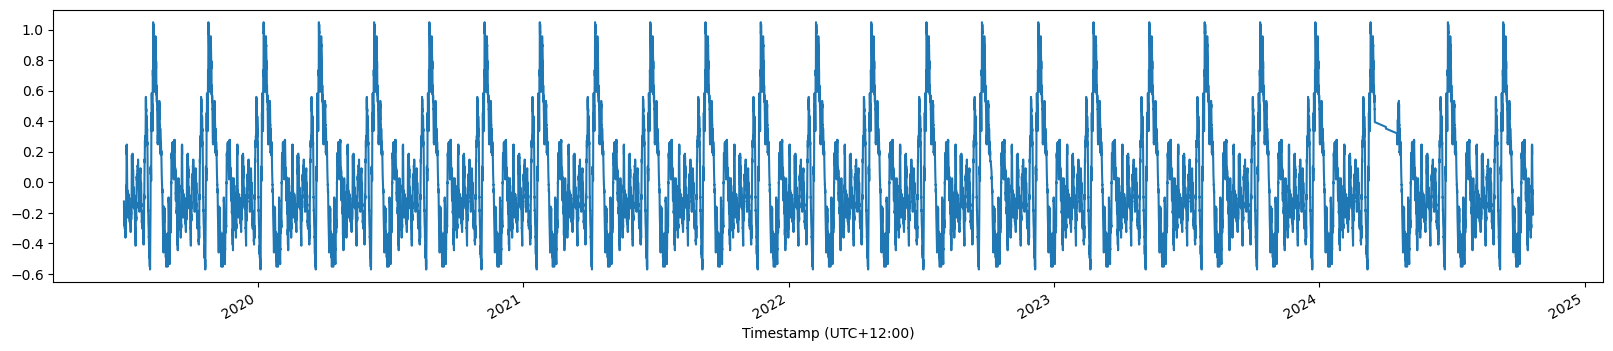

In [ ]:
result.seasonal.plot(figsize=(20,4))

In [ ]:
24 * 365 /4
# Winter: 90 days (December to February)
# Spring: 92 days (March to May)
# Summer: 92 days (June to August)
# Autumn: 91 days (September to November)

2190.0

this to find the p, d, q and P,D, Q
- check model, check AIC

In [ ]:
auto_arima(mtalbert_hourly['SoilMoisture(%)'], seasonal=True, m=365 ).summary()

In [ ]:
train_len = len(mtalbert_hourly) * 0.8

In [ ]:
train = mtalbert_hourly.iloc[:train_len]
test = mtalbert_hourly.iloc[train_len:]

In [ ]:
model = SARIMAX(train['SoilMoisture(%)'], order=(0,1,1), seasonal_order=(1,0,1,12))

In [ ]:
results = model.fit()
result.sumary()

Predictive Model

In [ ]:
start = len(train)
end = len(train) + len(test) -1

In [ ]:
# train = mtalbert[['Rain(mm)', 'SoilTemp(c)']]
# test = mtalbert[['SoilMoisture(%)']]

In [ ]:
sarima_predictions = results.predict(start, end, typ="levels").rename('Sarima Predictions')

In [ ]:
test['SoilMoisture(%)'].plog(legend=True, figsize=(8,5))
sarima_predictions.plot(legend=True)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

def evaluate_model(predictions, y_test):
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, predictions)

    return mae, mse, rmse, r2

sa_mae, sa_mse, sa_rmse, sa_r2 = evaluate_model(sarima_predictions, test)

print("\nRandom Forest Testing Set Metrics:")
print(f"MAE: {sa_mae}")
print(f"MSE: {sa_mse}")
print(f"RMSE: {sa_rmse}")
print(f"R2 Score: {sa_r2}")


Random Forest Testing Set Metrics:
MAE: 3.4216221902485104
MSE: 17.11547249036288
RMSE: 4.137085023342267
R2 Score: 0.3552786080951448


Forecast into the unknown future

In [ ]:
model = SARIMAX(mtalbert_hourly['SoilMoisture(%)'], order=(0,1,1), seasonal_order=(1,0,1,12))
result = model.fit()

In [ ]:
fcast = results.predict(len(mtalbert_hourly), len(mtalbert_hourly) + 24)